# Loading EEG data and plotting an ERP

Welcome to this IPython notebook. This page is a live interface to a running Python instance, where we create 'cells'. A cell is either some text (which can include images and formulas) or code, in which case we can execute that code by pressing `shift+enter`. See the [notebook documentation](http://ipython.org/ipython-doc/stable/interactive/htmlnotebook.html) for an overview of the functionality of this environment.

I'm going to assume some basic knowledge about Python ([tutorial](http://docs.python.org/tutorial)), Numpy ([tutorial](http://www.scipy.org/Tentative_NumPy_Tutorial)) and Matplotlib ([tutorial](http://matplotlib.org/users/pyplot_tutorial.html)).

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## The Magic Trick
In this tutorial we will do some simple EEG data analysis in order to *'read'* a subjects mind. This experiment is playfully called the "magic trick". The subject was sitting in front of a screen and was presented with 9 playing cards:

In [2]:
cards = [
    'Ace of spades',
    'Jack of clubs',
    'Queen of hearts',
    'King of diamonds',
    '10 of spaces',
    '3 of clubs',
    '10 of hearts',
    '3 of diamonds',
    'King of spades',
]

He picked one of these cards and kept it in his mind. Next, the 9 playing cards would flash one-by-one in a random order across the screen. Each card was presented a total of 30 times. The subject would mentally count the number of times his card would appear on the screen (which was 30 if he was paying attention, we are not interested in the answer he got, it just helps keep the subject focused on the cards).

In this tutorial we will analyse the average response to each card. The card that the subject had in mind should produce a larger response than the others.

First off, let's download the data. I've created a public dropbox folder where I store it. Execute the code below by pressing `ctrl+enter`. It will take some time to run, depending on the speed of your internet connection.

**NOTE:** The data used in this tutorial is EEG data that has been bandpass filtered with a 3rd order Butterworth filter with a passband of 0.5-30 Hz. This results in relatively clean looking data. When doing ERP analysis on other data, you will probably have to filter it yourself. Don't do ERP analysis on non-filtered, non-baselined data! Bandpass filtering is covered in the 3rd tutorial.

In [3]:
import urllib
urllib.urlretrieve('https://www.dropbox.com/s/c3iwvcy12e98p58/tutorial1-01.mat?dl=1', 'tutorial1-01.mat');

After the above code has finished running, we have a file `tutorial1-01.mat` in our current directory. It is stored in the default MATLAB format, which we can load by using the [SciPy](http://docs.scipy.org/doc/scipy/reference/index.html#) module: 

In [4]:
import scipy.io
m = scipy.io.loadmat('tutorial1-01.mat')
print m.keys()

['labels', 'EEG', '__version__', '__header__', '__globals__']


The [`scipy.io.loadmat`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) function returns a [dictionary](http://docs.python.org/library/stdtypes.html#mapping-types-dict) containing the variables stored in the matlab file. Two of them are of interest to us, the actual `EEG` and the `labels` which indicate at which point in time which card was presented to the subject.

In [5]:
EEG = m['EEG']
labels = m['labels'].flatten()

print 'EEG dimensions:', EEG.shape
print 'Label dimensions:', labels.shape

EEG dimensions: (7, 288349)
Label dimensions: (288349,)


The `EEG` variable is a [Numpy Array](http://www.scipy.org/Tentative_NumPy_Tutorial) containing 7 rows that contain the signal collected from 7 electrodes. The `label` variable contains the output of our trigger cable, which was used to synchronize the EEG signal with what was happening on the screen. Every time we presented a card on the screen, we send a non-zero value through the trigger cable. The `labels` variable will therefore contain mostly zeros, but non-zero values at the moments in time we presented a card to the subject. Lets plot the raw EEG data:

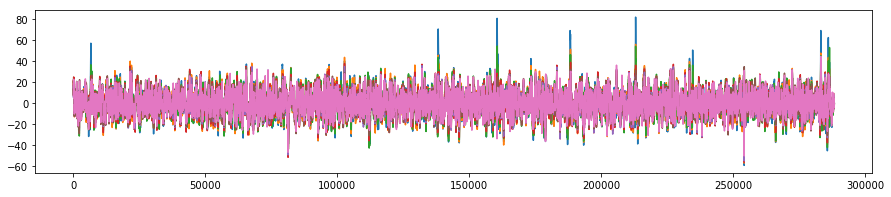

In [8]:
figure(figsize=(15,3))
plot(EEG.T)

All channels are drawn on top of each other, which is not convenient. Usually, EEG data is plotted with the channels horizontally stacked, an artefact stemming from the days where EEG machines drew on large rolls of paper. Lets add a constant value to each EEG channel before plotting them and some decoration like a meaningful x and y axis. I'll write this as a function, since this will come in handy later on:

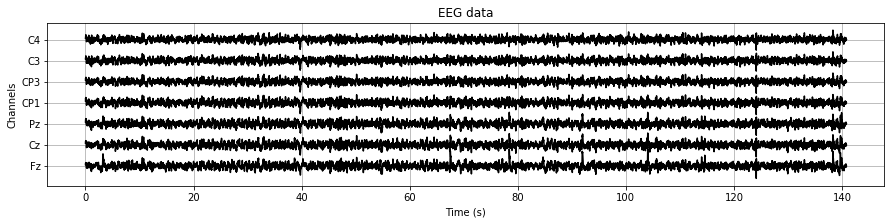

In [9]:
from matplotlib.collections import LineCollection

def plot_eeg(EEG, vspace=100, color='k'):
    '''
    Plot the EEG data, stacking the channels horizontally on top of each other.

    Parameters
    ----------
    EEG : array (channels x samples)
        The EEG data
    vspace : float (default 100)
        Amount of vertical space to put between the channels
    color : string (default 'k')
        Color to draw the EEG in
    '''
    
    bases = vspace * arange(7) # vspace * 0, vspace * 1, vspace * 2, ..., vspace * 6
    
    # To add the bases (a vector of length 7) to the EEG (a 2-D Matrix), we don't use
    # loops, but rely on a NumPy feature called broadcasting:
    # http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
    EEG = EEG.T + bases
    
    # Calculate a timeline in seconds, knowing that the sample rate of the EEG recorder was 2048 Hz.
    samplerate = 2048.
    time = arange(EEG.shape[0]) / samplerate
    
    # Plot EEG versus time
    plot(time, EEG, color=color)

    # Add gridlines to the plot
    grid()
    
    # Label the axes
    xlabel('Time (s)')
    ylabel('Channels')
    
    # The y-ticks are set to the locations of the electrodes. The international 10-20 system defines
    # default names for them.
    gca().yaxis.set_ticks(bases)
    gca().yaxis.set_ticklabels(['Fz', 'Cz', 'Pz', 'CP1', 'CP3', 'C3', 'C4'])
    
    # Put a nice title on top of the plot
    title('EEG data')

# Testing our function
figure(figsize=(15,3))
plot_eeg(EEG)

And to top it off, lets add vertical lines whenever a card was shown to the subject: 

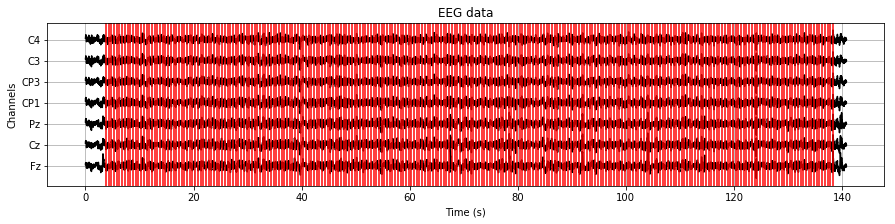

In [10]:
figure(figsize=(15,3))
plot_eeg(EEG)
for onset in flatnonzero(labels):
    axvline(onset / 2048., color='r')


As you can see, cards were shown at a rate of 2 per second. 

We are interested in the response generated whenever a card was shown, so we cut one-second-long pieces of EEG signal that start from the moment a card was shown. These pieces will be named 'trials'. A useful function here is [`flatnonzero`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.flatnonzero.html) which returns all the indices of an array which contain to a non-zero value. It effectively gives us the time (as an index) when a card was shown, if we use it in a clever way.

In [11]:
onsets = flatnonzero(labels)
print onsets[:10]
print 'Number of onsets:', len(onsets)

classes = labels[onsets]
print 'Card shown at each onset:', classes[:10]

[ 7789  8790  9814 10838 11862 12886 13910 14934 15958 16982]
Number of onsets: 270
Card shown at each onset: [3 6 7 9 1 8 5 2 4 9]


Lets create a 3-dimensional array containing all the trials:

In [10]:
nchannels = 7 # 7 EEG channels
sample_rate = 2048. # The sample rate of the EEG recording device was 2048Hz
nsamples = int(1.0 * sample_rate) # one second's worth of data samples
ntrials = len(onsets)

trials = zeros((ntrials, nchannels, nsamples))
for i, onset in enumerate(onsets):
    trials[i, :, :] = EEG[:, onset:onset + nsamples]
    
print trials.shape

(270, 7, 2048)


Lets plot one of the trials:

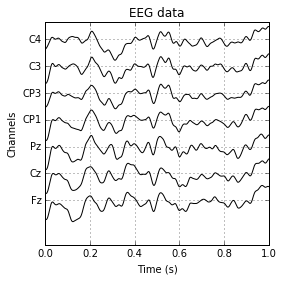

In [11]:
figure(figsize=(4,4))
plot_eeg(trials[0,:,:], vspace=30)

Looking at the individual trials is not all that informative. Lets calculate the average response to each card and plot that. To get all the trials where a particular card was shown, I use a trick called [logical indexing](http://docs.scipy.org/doc/numpy/user/basics.indexing.html#boolean-or-mask-index-arrays).

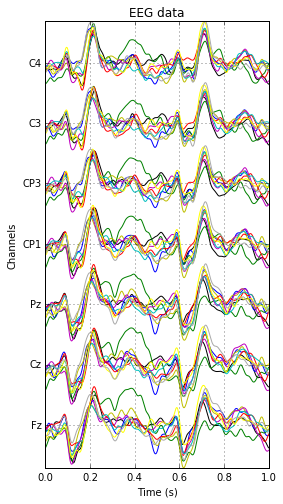

In [12]:
# Lets give each response a different color
colors = ['k', 'b', 'g', 'y', 'm', 'r', 'c', '#ffff00', '#aaaaaa']

figure(figsize=(4,8))

# Plot the mean EEG response to each card, such an average is called an ERP in the literature
for i in range(len(cards)):
    # Use logical indexing to get the right trial indices
    erp = mean(trials[classes == i+1, :, :], axis=0)
    plot_eeg(erp, vspace=20, color=colors[i])

One of the cards jumps out: the one corresponding to the green line. You can see it most clearly at channel Cz around 0.4 seconds. This line corresponds the the 3rd card which turns out to be:

In [13]:
cards[2]

'Queen of hearts'

Lets try our hand at an algorithm that automatically determines which card was picked by the user. The first step is to make some estimate of the P300 amplitude for each trial. We see the P300 peaks somewhere in time interval from 0.3 to 0.5. Let's take the mean voltage in that time interval as an estimate:

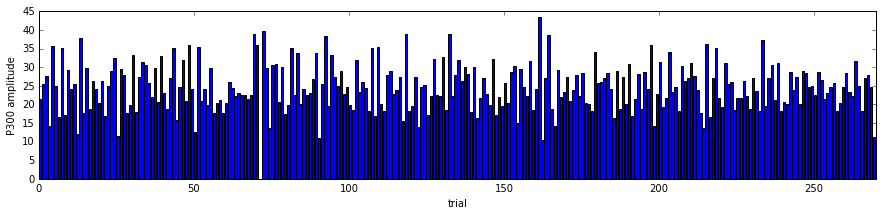

In [14]:
from_index = int(0.3 * sample_rate)
to_index = int(0.5 * sample_rate)
p300_amplitudes = mean(mean(trials[:, :, from_index:to_index], axis=1), axis=1)
p300_amplitudes -= min(p300_amplitudes) # Make them all positive

# Plot for each trial the estimate of the P300 amplitude
figure(figsize=(15,3))
bar(range(ntrials), p300_amplitudes)
xlim(0, ntrials)
xlabel('trial')
ylabel('P300 amplitude')

Peaks in the graph above should line up with the times that the chosen card was shown:

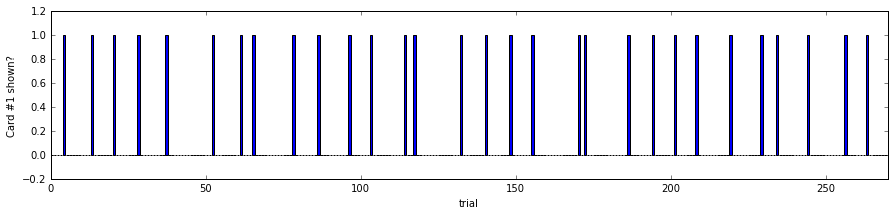

In [15]:
# Plot the times at which the first card was shown
figure(figsize=(15,3))
bar(range(ntrials), classes == 1)
xlim(0, ntrials)
ylim(-0.2, 1.2)
xlabel('trial')
ylabel('Card #1 shown?')

To have some score of how well peaks in P300 amplitude line up with times that the card was shown, we can use Pearson's correlation function:

In [16]:
from scipy.stats import pearsonr
pearsonr(classes == 1, p300_amplitudes)[0]

0.05113327503234491

All that's left is to calculate this score for each card, and pick the card with the highest score:

Was your card the Queen of hearts?


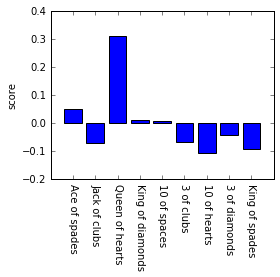

In [17]:
nclasses = len(cards)
scores = [pearsonr(classes == i+1, p300_amplitudes)[0] for i in range(nclasses)]

# Plot the scores
figure(figsize=(4,3))
bar(arange(nclasses)+1, scores, align='center')
xticks(arange(nclasses)+1, cards, rotation=-90)
ylabel('score')

# Pick the card with the highest score
winning_card = argmax(scores)
print 'Was your card the %s?' % cards[winning_card]